In [ ]:
!pip install torch_geometric
!pip install --upgrade rich
!pip install opacus
!pip install wandb
!pip install dask_jobqueue
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 4.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinu

In [ ]:
!pip install class_resolver

Writing a class to download and process the Facebook dataset, which is seemingly the smallest sized-dataset upon which this analysis was performed :


In [ ]:
import os
import ssl
import torch
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import LabelEncoder
from torch_geometric.utils import subgraph, from_scipy_sparse_matrix
from torch_geometric.data import Data, InMemoryDataset, download_url


class Facebook(InMemoryDataset):
    url = 'https://github.com/sisaman/pyg-datasets/raw/main/datasets/facebook100/'
    targets = ['status', 'gender', 'major', 'minor', 'housing', 'year']
    available_datasets = [
        "Villanova62", "UCLA26", "Tennessee95", "NYU9", "Carnegie49", "GWU54", "USF51", "Vanderbilt48",
        "USC35", "Rutgers89", "UConn91", "MIT8", "USFCA72", "UChicago30", "UIllinois20", "UC61", "Cal65",
        "Yale4", "Northeastern19", "Dartmouth6", "Vermont70", "Northwestern25", "William77", "Harvard1",
        "Princeton12", "UC64", "Middlebury45", "Haverford76", "Bingham82", "UNC28", "Berkeley13", "Rochester38",
        "Swarthmore42", "Virginia63", "WashU32", "Columbia2", "NotreDame57", "Bucknell39", "UVA16", "Maine59",
        "MU78", "Simmons81", "MSU24", "Colgate88", "Temple83", "Cornell5", "Indiana69", "Oklahoma97", "Michigan23",
        "BU10", "Brown11", "Auburn71", "FSU53", "UGA50", "UCF52", "Howard90", "UCSD34", "Vassar85", "Tufts18",
        "UPenn7", "Baylor93", "UMass92", "Bowdoin47", "Maryland58", "Penn94", "Wesleyan43", "UC33",
        "Rice31", "UCSC68", "Smith60", "Caltech36", "Hamilton46", "Oberlin44", "American75", "Mich67",
        "Mississippi66", "Williams40", "UCSB37", "Amherst41", "Duke14", "Pepperdine86", "Wake73", "Lehigh96",
        "Reed98", "Tulane29", "Texas84", "Wellesley22", "JMU79", "Santa74", "Wisconsin87", "Stanford3",
        "Texas80", "UF21", "JohnsHopkins55", "Syracuse56", "BC17", "Georgetown15", "Trinity100", "Brandeis99", "Emory27",
    ]

    def __init__(self, root: str, name: str, target='status', transform=None, pre_transform=None):
        self.name = name
        self.target = target
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_dir(self) -> str:
        return os.path.join(self.root, self.name, 'raw')

    @property
    def raw_file_names(self) -> str:
        return self.name + '.mat'

    @property
    def processed_dir(self) -> str:
        return os.path.join(self.root, self.name, 'processed')

    @property
    def processed_file_names(self) -> str:
        return f'data-{self.name}-{self.target}.pt'

    def download(self):
        context = ssl._create_default_https_context
        ssl._create_default_https_context = ssl._create_unverified_context
        download_url(f'{self.url}/{self.raw_file_names}', self.raw_dir)
        ssl._create_default_https_context = context

    def process(self):
        mat = loadmat(os.path.join(self.raw_dir, self.raw_file_names))
        features = pd.DataFrame(mat['local_info'][:, :-1], columns=self.targets)
        y = torch.from_numpy(LabelEncoder().fit_transform(features[self.target]))
        if 0 in features[self.target].values:
            y = y - 1

        x = features.drop(columns=self.target).replace({0: None})
        x = torch.tensor(pd.get_dummies(x).values, dtype=torch.float)
        edge_index = from_scipy_sparse_matrix(mat['A'])[0]

        # removed unlabled nodes
        subset = y >= 0
        edge_index, _ = subgraph(subset, edge_index, relabel_nodes=True, num_nodes=len(y))
        x = x[subset]
        y = y[subset]

        data = Data(x=x, edge_index=edge_index, y=y)

        if self.pre_transform is not None:
            data = self.pre_transform(data)

        torch.save(self.collate([data]), self.processed_paths[0])

    def __repr__(self) -> str:
        return f'Facebook-{self.name}()'


class FB100(InMemoryDataset):
    url = 'https://github.com/sisaman/pyg-datasets/raw/main/datasets/facebook100/'
    targets = ['status', 'gender', 'major', 'minor', 'housing', 'year']
    available_datasets = [
        "Villanova62", "UCLA26", "Tennessee95", "NYU9", "Carnegie49", "GWU54", "USF51", "Vanderbilt48",
        "USC35", "Rutgers89", "UConn91", "MIT8", "USFCA72", "UChicago30", "UIllinois20", "UC61", "Cal65",
        "Yale4", "Northeastern19", "Dartmouth6", "Vermont70", "Northwestern25", "William77", "Harvard1",
        "Princeton12", "UC64", "Middlebury45", "Haverford76", "Bingham82", "UNC28", "Berkeley13", "Rochester38",
        "Swarthmore42", "Virginia63", "WashU32", "Columbia2", "NotreDame57", "Bucknell39", "UVA16", "Maine59",
        "MU78", "Simmons81", "MSU24", "Colgate88", "Temple83", "Cornell5", "Indiana69", "Oklahoma97", "Michigan23",
        "BU10", "Brown11", "Auburn71", "FSU53", "UGA50", "UCF52", "Howard90", "UCSD34", "Vassar85", "Tufts18",
        "UPenn7", "Baylor93", "UMass92", "Bowdoin47", "Maryland58", "Penn94", "Wesleyan43", "UC33",
        "Rice31", "UCSC68", "Smith60", "Caltech36", "Hamilton46", "Oberlin44", "American75", "Mich67",
        "Mississippi66", "Williams40", "UCSB37", "Amherst41", "Duke14", "Pepperdine86", "Wake73", "Lehigh96",
        "Reed98", "Tulane29", "Texas84", "Wellesley22", "JMU79", "Santa74", "Wisconsin87", "Stanford3",
        "Texas80", "UF21", "JohnsHopkins55", "Syracuse56", "BC17", "Georgetown15", "Trinity100", "Brandeis99", "Emory27",
    ]

    def __init__(self, root: str, target='status', transform=None, pre_transform=None):
        self.target = target
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_dir(self) -> str:
        return os.path.join(self.root, 'raw')

    @property
    def raw_file_names(self) -> list[str]:
        return [f'{name}.mat' for name in self.available_datasets]

    @property
    def processed_dir(self) -> str:
        return os.path.join(self.root, 'processed')

    @property
    def processed_file_names(self) -> str:
        return f'data-{self.target}.pt'

    def download(self):
        context = ssl._create_default_https_context
        ssl._create_default_https_context = ssl._create_unverified_context
        for name in self.raw_file_names:
            download_url(f'{self.url}/{name}', self.raw_dir)
        ssl._create_default_https_context = context

    def process(self):
        features = pd.DataFrame()
        edge_index = torch.tensor([], dtype=torch.long)

        for i, raw_file_name in enumerate(self.raw_file_names):
            mat = loadmat(os.path.join(self.raw_dir, raw_file_name))
            mat_features = pd.DataFrame(mat['local_info'][:, :-1], columns=self.targets)
            mat_edge_index = from_scipy_sparse_matrix(mat['A'])[0] + len(features)
            if i < 75:
                mat_features['split'] = 'train'
            elif i < 85:
                mat_features['split'] = 'val'
            else:
                mat_features['split'] = 'test'
            features = pd.concat([features, mat_features], ignore_index=True)
            edge_index = torch.cat([edge_index, mat_edge_index], dim=1)

        y = torch.from_numpy(LabelEncoder().fit_transform(features[self.target]))
        if 0 in features[self.target].values:
            y = y - 1

        x = features.drop(columns=[self.target, 'minor', 'housing', 'split']).replace({0: None})
        x = torch.tensor(pd.get_dummies(x).values, dtype=torch.float)

        train_mask = torch.from_numpy((features['split'] == 'train').values)
        val_mask = torch.from_numpy((features['split'] == 'val').values)
        test_mask = torch.from_numpy((features['split'] == 'test').values)

        # removed unlabled nodes
        subset = y >= 0
        edge_index, _ = subgraph(subset, edge_index, relabel_nodes=True, num_nodes=len(y))
        x = x[subset]
        y = y[subset]
        train_mask = train_mask[subset]
        val_mask = val_mask[subset]
        test_mask = test_mask[subset]

        data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)

        if self.pre_transform is not None:
            data = self.pre_transform(data)

        torch.save(self.collate([data]), self.processed_paths[0])

    def __repr__(self) -> str:
        return f'Facebook-100()'

### Reddit dataset is a pre-loaded dataset in `PyTorch Geometric`.

In [ ]:
from torch_geometric.datasets import Reddit

Adding some helper functions, as well as a Console to push the extracted data entities onto,

* In the following section, we define a helper function that converts dictionary data structure to a table format for viewing purposes.

In [ ]:
import math
from typing import Callable, Optional
import numpy as np
from numpy.typing import ArrayLike, NDArray
from rich.table import Table
from rich.highlighter import ReprHighlighter
from rich import box
from tabulate import tabulate


def dict2table(input_dict: dict, num_cols: int = 4, title: Optional[str] = None) -> Table:
    num_items = len(input_dict)
    num_rows = math.ceil(num_items / num_cols)
    col = 0
    data = {}
    keys = []
    vals = []

    for i, (key, val) in enumerate(input_dict.items()):
        keys.append(f'{key}:')

        vals.append(val)
        if (i + 1) % num_rows == 0:
            data[col] = keys
            data[col+1] = vals
            keys = []
            vals = []
            col += 2

    data[col] = keys
    data[col+1] = vals

    highlighter = ReprHighlighter()
    message = tabulate(data, tablefmt='plain')
    table = Table(title=title, show_header=False, box=box.HORIZONTALS)
    table.add_row(highlighter(message))
    return table

In [ ]:
from rich.console import Console as RichConsole
from rich.logging import RichHandler
from rich.spinner import Spinner
from rich.table import Table
from rich.status import Status
from rich.live import Live
from rich._log_render import LogRender
from time import time
import logging


class LogStatus(Status):
    def __init__(self,
        status,
        console: RichConsole,
        level: int = logging.INFO,
        enabled: bool = True,
        speed: float = 1.0,
        refresh_per_second: float = 12.5,
    ):
        super().__init__(status,
            console=console,
            spinner='simpleDots',
            speed=speed,
            refresh_per_second=refresh_per_second
        )

        self.status = status
        self.level = level
        self.enabled = enabled
        spinner = Spinner('simpleDots', style='status.spinner', speed=speed)
        record = logging.LogRecord(name=None, level=level, pathname=None, lineno=None, msg=None, args=None, exc_info=None)
        handler = RichHandler(console=console)
        table = Table.grid()
        table.add_row(self.status, spinner)

        self._spinner = LogRender(show_level=True, time_format='[%X]')(
            console=console,
            level=handler.get_level_text(record),
            renderables=[table]
        )
        self._live = Live(
            self.renderable,
            console=console,
            refresh_per_second=refresh_per_second,
            transient=True,
        )

    def __enter__(self):
        if self.enabled:
            self._start_time = time()
            return super().__enter__()

    def __exit__(self, exc_type, exc_val, exc_tb):
        if self.enabled:
            super().__exit__(exc_type, exc_val, exc_tb)
            self._end_time = time()
            self.console.log(f'{self.status}...done in {self._end_time - self._start_time:.2f} s', level=self.level)

In [ ]:
import os
import logging
from rich.console import Console as RichConsole
from rich.logging import RichHandler
from typing import Optional, Union
from rich.console import JustifyMethod, NewLine
from rich.scope import render_scope
from rich.segment import Segment
from rich.styled import Styled
from rich.style import Style

class Console(RichConsole):
    CRITICAL = logging.CRITICAL
    FATAL = logging.FATAL
    ERROR = logging.ERROR
    WARNING = logging.WARNING
    WARN = logging.WARN
    INFO = logging.INFO
    DEBUG = logging.DEBUG
    NOTSET = logging.NOTSET

    def __init__(self, *args, log_level: int = INFO, **kwrags):
        super().__init__(*args, **kwrags)
        self.log_level = log_level

    def status (self, status: str, level: int=INFO) -> LogStatus:
        return LogStatus(status, console=self, level=level, enabled=level >= self.log_level)

    def log(
        self,
        *objects,
        level: int = logging.INFO,
        sep: str = " ",
        end: str = "\n",
        style: Union[str, Style] = None,
        justify: Optional[JustifyMethod] = None,
        emoji: Optional[bool] = None,
        markup: Optional[bool] = None,
        highlight: Optional[bool] = None,
        log_locals: bool = False,
        _stack_offset: int = 2,
    ) -> None:
        """Log rich content to the terminal.
        Args:
            objects (positional args): Objects to log to the terminal.
            sep (str, optional): String to write between print data. Defaults to " ".
            end (str, optional): String to write at end of print data. Defaults to "\\\\n".
            style (Union[str, Style], optional): A style to apply to output. Defaults to None.
            justify (str, optional): One of "left", "right", "center", or "full". Defaults to ``None``.
            emoji (Optional[bool], optional): Enable emoji code, or ``None`` to use console default. Defaults to None.
            markup (Optional[bool], optional): Enable markup, or ``None`` to use console default. Defaults to None.
            highlight (Optional[bool], optional): Enable automatic highlighting, or ``None`` to use console default. Defaults to None.
            log_locals (bool, optional): Boolean to enable logging of locals where ``log()``
                was called. Defaults to False.
            _stack_offset (int, optional): Offset of caller from end of call stack. Defaults to 1.
        """
        if level < self.log_level:
            return

        if not objects:
            objects = (NewLine(),)

        render_hooks = self._render_hooks[:]

        with self:
            renderables = self._collect_renderables(
                objects, sep, end, justify=justify, emoji=emoji, markup=markup, highlight=highlight
            )
            if style is not None:
                renderables = [Styled(renderable, style) for renderable in renderables]

            filename, line_no, locals = self._caller_frame_info(_stack_offset)
            link_path = None if filename.startswith("<") else os.path.abspath(filename)
            path = filename.rpartition(os.sep)[-1]
            if log_locals:
                locals_map = {key: value for key, value in locals.items() if not key.startswith("__")}
                renderables.append(render_scope(locals_map, title="[i]locals"))

            record = logging.LogRecord(name=None, level=level, pathname=None, lineno=None, msg=None, args=None, exc_info=None)
            handler = RichHandler(console=self)
            self._log_render.show_level = True

            renderables = [
                self._log_render(
                    self,
                    renderables,
                    level=handler.get_level_text(record),
                    log_time=self.get_datetime(),
                    path=path,
                    line_no=line_no,
                    link_path=link_path,
                )
            ]
            for hook in render_hooks:
                renderables = hook.process_renderables(renderables)
            new_segments = []
            extend = new_segments.extend
            render = self.render
            render_options = self.options
            for renderable in renderables:
                extend(render(renderable, render_options))
            buffer_extend = self._buffer.extend
            for line in Segment.split_and_crop_lines(new_segments, self.width, pad=False):
                buffer_extend(line)

    def debug(self, *args, **kwargs):
        self.log(*args, level=self.DEBUG, **kwargs)

    def info(self, *args, **kwargs):
        self.log(*args, level=self.INFO, **kwargs)

    def warning(self, *args, **kwargs):
        self.log(*args, level=self.WARNING, **kwargs)

    def error(self, *args, **kwargs):
        self.log(*args, level=self.ERROR, **kwargs)

Writing functions to perform data-preprocessing and filtering.

The following class acts upon the dataset, selecting the entries such that we specify the minimum clount of the class to be retained and also allows us to remove unlabeled data from the dataset.

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.transforms import BaseTransform
from torch_geometric.data import Data


class FilterClassByCount(BaseTransform):
    def __init__(self, min_count: int, remove_unlabeled=False):
        self.min_count = min_count
        self.remove_unlabeled = remove_unlabeled

    def __call__(self, data: Data) -> Data:
        assert hasattr(data, 'y')

        y: torch.Tensor = F.one_hot(data.y)
        counts = y.sum(dim=0)
        y = y[:, counts >= self.min_count]
        mask = y.sum(dim=1).bool()        # nodes to keep
        data.y = y.argmax(dim=1)

        if self.remove_unlabeled:
            data = data.subgraph(mask)
        else:
            data.y[~mask] = -1                # set filtered nodes as unlabeled
            if hasattr(data, 'train_mask'):
                data.train_mask = data.train_mask & mask
                data.val_mask = data.val_mask & mask
                data.test_mask = data.test_mask & mask

        return data

The following class creates a mask for the entire graph, sets its value as TRUE for the nodes connected via edges, and applies this mask onto the graph to filter out the nodes that are not connected to any other node.

In [ ]:
from torch_geometric.transforms import BaseTransform
from torch_geometric.data import Data


class RemoveIsolatedNodes(BaseTransform):
    def __call__(self, data: Data) -> Data:
        mask = data.y.new_zeros(data.num_nodes, dtype=bool)
        mask[data.edge_index[0]] = True
        mask[data.edge_index[1]] = True
        data = data.subgraph(mask)
        return data

The following class removes self loops from the graph data structure, if any.

In [ ]:
from torch_geometric.utils import remove_self_loops
from torch_geometric.transforms import BaseTransform
from torch_geometric.data import Data


class RemoveSelfLoops(BaseTransform):
    def __call__(self, data: Data) -> Data:
        if hasattr(data, 'edge_index') and data.edge_index is not None:
            data.edge_index, _ = remove_self_loops(data.edge_index)
        if hasattr(data, 'adj_t'):
            data.adj_t = data.adj_t.remove_diag()
        return data

Now, for transductive setting, we require that the same graph entity be used for training, testing and validation. Hence, we need to predict nodes' labels, for those nodes that are already existent in the graph structure provided.

* Hence, we need to reserve subsets of nodes on the given graph, for training, testing and validation - a purpose for which we create masks.

* The following class essentially facilitates the random split of graph data into training, testing and validation sets based on the specified ratios and ensures that each class has a balanced representation in each split.

In [ ]:
import torch
from torch_geometric.transforms import BaseTransform
from torch_geometric.data import Data


class RandomDataSplit(BaseTransform):
    def __init__(self, num_nodes_per_class, train_ratio=0.7, test_ratio=0.2):
        self.num_nodes_per_class = num_nodes_per_class
        self.train_ratio = train_ratio
        self.test_ratio = test_ratio

    def __call__(self, data: Data) -> Data:
        y = data.y
        num_classes = y.max().item() + 1
        num_train_nodes_per_class = int(self.num_nodes_per_class * self.train_ratio)
        num_test_nodes_per_class = int(self.num_nodes_per_class * self.test_ratio)

        train_mask = torch.zeros_like(y, dtype=torch.bool)
        test_mask = torch.zeros_like(y, dtype=torch.bool)
        val_mask = torch.zeros_like(y, dtype=torch.bool)

        for c in range(num_classes):
            idx = (y == c).nonzero(as_tuple=False).view(-1)
            num_nodes = idx.size(0)
            if num_nodes >= self.num_nodes_per_class:
                idx = idx[torch.randperm(idx.size(0))][:self.num_nodes_per_class]
                train_mask[idx[:num_train_nodes_per_class]] = True
                test_mask[idx[num_train_nodes_per_class:num_train_nodes_per_class + num_test_nodes_per_class]] = True
                val_mask[idx[num_train_nodes_per_class + num_test_nodes_per_class:]] = True

        data.train_mask = train_mask
        data.test_mask = test_mask
        data.val_mask = val_mask

        return data

In [ ]:
from typing import Annotated, Callable, Literal, Union, get_args, get_origin
import inspect
from argparse import SUPPRESS, ArgumentParser, ArgumentTypeError, Namespace


ArgType = Union[Namespace, dict[str, object]]
ArgInfo = dict[str, object]

In [ ]:
import os
from functools import partial
from typing import Annotated
import torch
from torch_geometric.data import Data
from torch_geometric.datasets import Reddit
from torch_geometric.transforms import Compose, ToSparseTensor, RandomNodeSplit

def load_wenet(root: str, transform=None) -> Data:
    data = torch.load(os.path.join(root, 'data.pt'))
    data = data if transform is None else transform(data)
    return [data]


class DatasetLoader:
    supported_datasets = {
        'reddit': partial(Reddit,
            pre_transform=Compose([
                RandomNodeSplit(num_val=0.1, num_test=0.15),
                FilterClassByCount(min_count=10000, remove_unlabeled=True),
                RemoveSelfLoops(), RemoveIsolatedNodes(),
            ])
        ),
        'facebook': partial(Facebook, name='UIllinois20', target='year',
            pre_transform=Compose([
                RandomNodeSplit(num_val=0.1, num_test=0.15),
                FilterClassByCount(min_count=1000, remove_unlabeled=True),
                RemoveSelfLoops(), RemoveIsolatedNodes(),
            ])
        ),
        'fb-100': partial(FB100, target='year',
            pre_transform=Compose([
                RandomNodeSplit(num_val=0.1, num_test=0.15),
                FilterClassByCount(min_count=100000, remove_unlabeled=True),
                RemoveSelfLoops(), RemoveIsolatedNodes(),
            ])
        )
    }
    console = Console()

    def __init__(self,
                 dataset:    Annotated[str, ArgInfo(help='name of the dataset', choices=supported_datasets)] = 'facebook',
                 data_dir:   Annotated[str, ArgInfo(help='directory to store the dataset')] = './datasets',
                 ):

        self.name = dataset
        self.data_dir = data_dir
        self.console = Console()

    def load(self, verbose=False) -> Data:
        data = self.supported_datasets[self.name](root=os.path.join(self.data_dir, self.name))[0]
        data = ToSparseTensor(layout=torch.sparse_csr)(data)

        if verbose:
            self.print_stats(data)

        return data

    def print_stats(self, data: Data):
        nodes_degree: torch.Tensor = data.adj_t.to_sparse_coo().sum(dim=1).to_dense() # in degree
        baseline: float = (data.y[data.test_mask].unique(return_counts=True)[1].max().item() * 100 / data.test_mask.sum().item())
        train_ratio: float = data.train_mask.sum().item() / data.num_nodes * 100
        val_ratio: float = data.val_mask.sum().item() / data.num_nodes * 100
        test_ratio: float = data.test_mask.sum().item() / data.num_nodes * 100

        stat = {
            'nodes': f'{data.num_nodes:,}',
            'edges': f'{data.num_edges:,}',
            'features': f'{data.num_features:,}',
            'classes': f'{int(data.y.max() + 1)}',
            'mean degree': f'{nodes_degree.mean():.2f}',
            'median degree': f'{nodes_degree.median()}',
            'train/val/test (%)': f'{train_ratio:.1f}/{val_ratio:.1f}/{test_ratio:.1f}',
            'baseline acc (%)': f'{baseline:.2f}'
        }

        table = dict2table(stat, num_cols=2, title=f'dataset: [yellow]{self.name}[/yellow]')
        self.console.info(table)
        self.console.print()

In [ ]:
# Initialize the DatasetLoader class with the desired dataset
loader = DatasetLoader(dataset='fb-100')

# Load the dataset
data = loader.load(verbose=True)

Processing...
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/utils/sparse.py:268: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  adj = torch.sparse_csr_tensor(


[15:00:32] INFO                           dataset: fb-100                        <ipython-input-13-a5a07c187594>:78
                     ──────────────────────────────────────────────────────────                                    
                      nodes:     1,120,280   mean degree:         77.04                                            
                      edges:     86,304,478  median degree:       57.0                                             
                      features:  537         train/val/test (%):                                                   
                      75.0/10.0/15.0                                                                               
                      classes:   6           baseline acc (%):    19.45                                            
                     ──────────────────────────────────────────────────────────                                    

In [ ]:
reddit_loader = DatasetLoader(dataset = 'reddit')
reddit_data = reddit_loader.load(verbose = True)
reddit_loader.print_stats(reddit_data)

Extracting datasets/reddit/raw/reddit.zip
Processing...
Done!


[15:01:26] INFO                           dataset: reddit                        <ipython-input-13-a5a07c187594>:78
                     ──────────────────────────────────────────────────────────                                    
                      nodes:     116,713     mean degree:         396.13                                           
                      edges:     46,233,380  median degree:       209.0                                            
                      features:  602         train/val/test (%):                                                   
                      75.1/9.9/15.0                                                                                
                      classes:   8           baseline acc (%):    24.37                                            
                     ──────────────────────────────────────────────────────────                                    

[15:01:29] INFO                           dataset: reddit                        <ipython-input-13-a5a07c187594>:78
                     ──────────────────────────────────────────────────────────                                    
                      nodes:     116,713     mean degree:         396.13                                           
                      edges:     46,233,380  median degree:       209.0                                            
                      features:  602         train/val/test (%):                                                   
                      75.1/9.9/15.0                                                                                
                      classes:   8           baseline acc (%):    24.37                                            
                     ──────────────────────────────────────────────────────────                                    

* Now, the dataset has been loaded, complete with the connectivity (adjacency
  matrix) - `adj_t`, `train_mask`, `test_mask`, `val_mask` and `y`.
* The feature matrix is stored under `data.x`

In [ ]:
print(data)

Data(x=[1120280, 537], y=[1120280], train_mask=[1120280], val_mask=[1120280], test_mask=[1120280], adj_t=[1120280, 1120280])


In [ ]:
loader.print_stats(data)

[15:01:35] INFO                           dataset: fb-100                        <ipython-input-13-a5a07c187594>:78
                     ──────────────────────────────────────────────────────────                                    
                      nodes:     1,120,280   mean degree:         77.04                                            
                      edges:     86,304,478  median degree:       57.0                                             
                      features:  537         train/val/test (%):                                                   
                      75.0/10.0/15.0                                                                               
                      classes:   6           baseline acc (%):    19.45                                            
                     ──────────────────────────────────────────────────────────                                    

In [ ]:
data.num_edges

86304478

Now, as present in the ProGAP paper, which establishes a baseline using MLP Classifier (not taking adjacency information into account) for edge-private case, we work to write code to perform such node-classfication using MLP.

* First, we write the class `TrainerProgress` to define a custom progress bar that aids our tracking of the training/testing processes while training any model.

In [ ]:
from typing import Literal, TypeVar
from torch.types import Number


RT = TypeVar('RT')
Phase = Literal['train', 'val', 'test', 'predict']
Metrics = dict[str, Number]

In [ ]:
from typing import Iterable
from rich.console import Group
from rich.padding import Padding
from rich.table import Column, Table
from rich.progress import Progress, SpinnerColumn, BarColumn, TimeElapsedColumn, Task
from rich.highlighter import ReprHighlighter





class TrainerProgress(Progress):
    def __init__(self,
                 num_epochs: int,
                 **kwargs
                 ):

        progress_bar = [
            SpinnerColumn(),
            "{task.description}",
            "[cyan]{task.completed:>3}[/cyan]/[cyan]{task.total}[/cyan]",
            "{task.fields[unit]}",
            BarColumn(),
            "[cyan]{task.percentage:>3.0f}[/cyan]%",
            TimeElapsedColumn(),
            # "{task.fields[metrics]}"
        ]

        console = Console()

        super().__init__(*progress_bar, console=console, **kwargs)

        self.trainer_tasks = {
            'epoch': self.add_task(total=num_epochs, metrics='', unit='epochs', description='overal progress'),
            'train': self.add_task(metrics='', unit='steps', description='training', visible=False),
            'val':   self.add_task(metrics='', unit='steps', description='validation', visible=False),
            'test':  self.add_task(metrics='', unit='steps', description='testing', visible=False),
        }

        self.max_rows = 0

    def update(self, task: Task, **kwargs):
        if 'metrics' in kwargs:
            kwargs['metrics'] = self.render_metrics(kwargs['metrics'])

        super().update(self.trainer_tasks[task], **kwargs)

    def reset(self, task: Task, **kwargs):
        super().reset(self.trainer_tasks[task], **kwargs)

    def render_metrics(self, metrics: Metrics) -> str:
        out = []
        for split in ['train', 'val', 'test']:
            metric_str = ' '.join(f'{k}: {v:.3f}' for k, v in metrics.items() if f'{split}/' in k)
            out.append(metric_str)

        return '  '.join(out)

    def make_tasks_table(self, tasks: Iterable[Task]) -> Table:
        """Get a table to render the Progress display.

        Args:
            tasks (Iterable[Task]): An iterable of Task instances, one per row of the table.

        Returns:
            Table: A table instance.
        """
        table_columns = (
            (
                Column(no_wrap=True)
                if isinstance(_column, str)
                else _column.get_table_column().copy()
            )
            for _column in self.columns
        )

        highlighter = ReprHighlighter()
        table = Table.grid(*table_columns, padding=(0, 1), expand=self.expand)

        if tasks:
            epoch_task = tasks[0]
            metrics = epoch_task.fields['metrics']

            for task in tasks:
                if task.visible:
                    table.add_row(
                        *(
                            (
                                column.format(task=task)
                                if isinstance(column, str)
                                else column(task)
                            )
                            for column in self.columns
                        )
                    )

            self.max_rows = max(self.max_rows, table.row_count)
            pad_top = 0 if epoch_task.finished else self.max_rows - table.row_count
            group = Group(table, Padding(highlighter(metrics), pad=(pad_top,0,0,2)))
            return Padding(group, pad=(0,0,1,18))

        else:
            return table

Since we are training multiple models on the given dataset, we require a template class that can be used to create trainable modules in PyTorch.
The following class `TrainableModule` does just that.

* This class abstracts away common functionalities related to optimization, such as configuring optimizers, handling forward passes, taking optimization steps, and making predictions.

In [ ]:
from typing import Optional
from torch import Tensor
from torch.nn import Module
from torch.optim.optimizer import Optimizer
from torch_geometric.data import Data
from abc import ABC, abstractmethod
from class_resolver.contrib.torch import optimizer_resolver

# Defined as a subclass of both Module and ABC, inheriting attributes from both.

# Serves as a base class for all the trainable modules in the project (nonPrivate, Edge-Private etc.)
class TrainableModule(Module, ABC):
    def __init__(self, optimizer: str, learning_rate: float, weight_decay: float):
        super().__init__()
        self.optimizer_name = optimizer
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

    @abstractmethod
    def forward(self, *args, **kwargs): pass

    @abstractmethod
    def step(self, data: Data, phase: Phase) -> tuple[Optional[Tensor], Metrics]: pass

    @abstractmethod
    def predict(self, data: Data) -> Tensor: pass

    @abstractmethod
    def reset_parameters(self): pass

    def configure_optimizers(self):
        optimizer = optimizer_resolver.make(
            query=self.optimizer_name,
            params=self.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay
        )
        return optimizer

In [ ]:
from abc import ABC, abstractmethod
from torch.nn import Module


class LoggerBase(ABC):
    @property
    @abstractmethod
    def experiment(self): pass

    @abstractmethod
    def log(self, metrics: dict[str, object]): pass

    @abstractmethod
    def log_summary(self, metrics: dict[str, object]): pass

    @abstractmethod
    def watch(self, model: Module, **kwargs): pass

    @abstractmethod
    def finish(self): pass

class DummyLogger(LoggerBase):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    @property
    def experiment(self): pass
    def log(self, metrics: dict[str, object]): pass
    def log_summary(self, metrics: dict[str, object]): pass
    def watch(self, model: Module, **kwargs): pass
    def finish(self): pass

In [ ]:
try:
    import wandb
    from wandb.wandb_run import Run
except ImportError:
    wandb = None


class WandbLogger(LoggerBase):
    def __init__(self, project: str, output_dir: str, config: dict = {}):
        self.project = project
        self.output_dir = output_dir
        self.config = config

        if wandb is None:
            raise ImportError(
                "wandb is not installed yet, install it with `pip install wandb`."
            )

    @property
    def experiment(self) -> Run:
        if not hasattr(self, "_experiment"):
            os.environ["WANDB_SILENT"] = "true"
            settings = wandb.Settings(start_method="fork")
            os.makedirs(self.output_dir, exist_ok=True)

            self._experiment = wandb.init(
                project=self.project,
                dir=self.output_dir,
                reinit=True,
                resume="allow",
                config=self.config,
                save_code=True,
                settings=settings,
            )

        return self._experiment

    def log(self, metrics: dict[str, object]):
        self.experiment.log(metrics)

    def log_summary(self, metrics: dict[str, object]):
        for metric, value in metrics.items():
            self.experiment.summary[metric] = value

    def watch(self, model: Module, **kwargs):
        self.experiment.watch(model, **kwargs)

    def finish(self):
        self.experiment.finish()

class Logger(LoggerBase):
    supported_loggers = {
        'wandb': WandbLogger
    }

    def __init__(self,
        logger:     Annotated[str,  ArgInfo(help='select logger type', choices=supported_loggers)] = None,
        project:    Annotated[str,  ArgInfo(help="project name for logger")] = 'ProGAP',
        output_dir: Annotated[str,  ArgInfo(help="directory to store the results")] = './output',
        config:     dict = {},
        prefix:     str = '',
        ) -> None:

        self.logger_name = logger
        self.project = project
        self.output_dir = output_dir
        self.config = config
        self.prefix = prefix

        if self.logger_name == 'wandb':
            self.logger = WandbLogger(
                project=project,
                output_dir=output_dir,
                config=config
            )
        else:
            self.logger = DummyLogger()

    @property
    def experiment(self):
        return self.logger.experiment

    def log(self, metrics: dict[str, object]):
        metrics = self._add_prefix(metrics)
        self.logger.log(metrics)

    def log_summary(self, metrics: dict[str, object]):
        metrics = self._add_prefix(metrics)
        self.logger.log_summary(metrics)

    def watch(self, model: Module, **kwargs):
        self.logger.watch(model, **kwargs)

    def finish(self):
        self.logger.finish()

    def set_prefix(self, prefix: str):
        self.prefix = prefix

    def _add_prefix(self, metrics: dict[str, object]) -> dict[str, object]:
        return {f'{self.prefix}{metric}': value for metric, value in metrics.items()}

Writing code to train our models -->
This class `Trainer` has an attribute defined, by the name of `model`, which is an initialization of the `TrainableModule` class. Hence, `Trainer` accesses any such module that is requried to be trained via this attribute.

* Secondly, all the information is cast to the `cuda` device, if present on the system.

* The reason I chose not to utilize logger for now is because I am not using any HPC cluster for my job.

In [ ]:
from copy import deepcopy
from typing import Iterable, Optional, Annotated, Literal
from torch.optim import Optimizer
from torch.types import Number
from torchmetrics import MeanMetric


class Trainer:
    def __init__(self,
                 monitor:       str = 'val/acc',
                 monitor_mode:  Literal['min', 'max'] = 'max',
                 epochs:        Annotated[int,  ArgInfo(help='number of epochs for training')] = 100,
                 device:        Annotated[str,  ArgInfo(help='device to use for training', choices=['cpu', 'cuda', 'auto'])] = 'auto',
                 verbose:       Annotated[bool, ArgInfo(help='display progress')] = True,
                 logger:        Logger = None,
                 ):

        self.epochs = epochs
        self.monitor = monitor
        self.monitor_mode = monitor_mode
        self.verbose = verbose
        self.logger = logger or DummyLogger()

        # setup device
        if device == 'auto':
            self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        else:
            self.device = torch.device(device)

        # trainer internal state
        self.model: TrainableModule = None
        self.metrics: dict[str, MeanMetric] = {}

    def reset(self) -> None:
        self.model = None
        self.metrics.clear()

    def update_metrics(self, metric_name: str, metric_value: object, batch_size: int = 1) -> None:
        # if this is a new metric, add it to self.metrics
        device = metric_value.device if torch.is_tensor(metric_value) else 'cpu'
        if metric_name not in self.metrics:
            self.metrics[metric_name] = MeanMetric().to(device)

        # update the metric
        self.metrics[metric_name].update(metric_value, weight=batch_size)

    def aggregate_metrics(self, phase: Phase='train') -> Metrics:
        metrics = {}

        for metric_name, metric_value in self.metrics.items():
            if phase in metric_name.split('/'):
                value = metric_value.compute()
                metric_value.reset()
                metrics[metric_name] = value

        return metrics

    def is_better(self, current_metric: Number, previous_metric: Number) -> bool:
        assert self.monitor_mode in ['min', 'max'], f'Unknown metric mode: {self.monitor_mode}'
        if self.monitor_mode == 'max':
            return current_metric > previous_metric
        elif self.monitor_mode == 'min':
            return current_metric < previous_metric

    def fit(self,
            model: TrainableModule,
            train_dataloader: Iterable,
            val_dataloader: Optional[Iterable]=None,
            test_dataloader: Optional[Iterable]=None,
            ) -> Metrics:

        self.model = model.to(self.device)
        self.optimizer: Optimizer = self.model.configure_optimizers()

        self.progress = TrainerProgress(
            num_epochs=self.epochs,
            disable=not self.verbose,
        )

        best_state_dict = None
        best_metrics = None

        with self.progress:
            for epoch in range(1, self.epochs + 1):
                metrics = {f'epoch': epoch}

                # train loop
                train_metrics = self.loop(train_dataloader, phase='train')
                metrics.update(train_metrics)

                # validation loop
                if val_dataloader:
                    val_metrics = self.loop(val_dataloader, phase='val')
                    metrics.update(val_metrics)

                    if best_metrics is None or self.is_better(
                        metrics[self.monitor], best_metrics[self.monitor]
                        ):
                        best_metrics = metrics
                        best_state_dict = deepcopy(self.model.state_dict())

                # test loop
                if test_dataloader:
                    test_metrics = self.loop(test_dataloader, phase='test')
                    metrics.update(test_metrics)

                # log and update progress
                self.progress.update(task='epoch', metrics=metrics, advance=1)
                self.logger.log(metrics)

        if best_metrics is None:
            best_metrics = metrics
        else:
            self.model.load_state_dict(best_state_dict)

        # log and return best metrics
        self.logger.log_summary(best_metrics)

        return best_metrics

    def test(self, dataloader: Iterable) -> Metrics:
        self.metrics.clear()
        metrics = self.loop(dataloader, phase='test')
        return metrics

    def predict(self, dataloader: Iterable, move_to_cpu: bool=False) -> Metrics:
        preds = []
        self.model.eval()
        with torch.no_grad():
            for batch in dataloader:
                batch = self.to_device(batch)
                # out might be a tuple of predictions
                out = self.model.predict(batch)
                if move_to_cpu:
                    out = out.cpu()
                preds.append(out)

        # concatenate predictions, check if they are tuples
        if isinstance(preds[0], tuple):
            preds = tuple(torch.cat([p[i] for p in preds]) for i in range(len(preds[0])))
        else:
            preds = torch.cat(preds)

        return preds

    def loop(self, dataloader: Iterable, phase: Phase) -> Metrics:
        self.model.train(phase == 'train')
        grad_state = torch.is_grad_enabled()
        torch.set_grad_enabled(phase == 'train')
        self.progress.update(phase, visible=len(dataloader) > 1, total=len(dataloader))

        for batch in dataloader:
            batch = self.to_device(batch)
            metrics = self.step(batch, phase)
            for item in metrics:
                self.update_metrics(item, metrics[item], batch_size=batch.batch_nodes.size(0))
            self.progress.update(phase, advance=1)

        self.progress.reset(phase, visible=False)
        torch.set_grad_enabled(grad_state)
        return self.aggregate_metrics(phase)

    def step(self, batch, phase: Phase) -> Metrics:
        if phase == 'train':
            self.optimizer.zero_grad(set_to_none=True)

        loss, metrics = self.model.step(batch, phase=phase)

        if phase == 'train':
            loss.backward()
            self.optimizer.step()

        return metrics

    def to_device(self, batch):
        if isinstance(batch, tuple):
            return tuple(item.to(self.device) for item in batch)
        return batch.to(self.device)

There is a custom node-wise dataloader defined in the following cell. It is provided with the graph `Data` object, containing the node features matrix, the `train`, `test` and `val` masks, etc.

* There are also options to specify other parameters.

* For our transductive setting, since we do not have any memory constraints to work on our sufficiently small-sized `Facebook` or `Reddit` dataset, we can specify the `batch_size` parameter as `full` to use the entire graph as a single batch.

In [ ]:
from typing import Literal, Optional, Union
import torch
from torch import Tensor
from collections.abc import Iterator
from torch_geometric.data import Data
from torch_geometric.utils import k_hop_subgraph, to_edge_index
from torch_geometric.transforms import ToSparseTensor


class NodeDataLoader:
    """ A fast dataloader for node-wise training.

    We have three settings:
    1. batch_size = 'full', hops = None
        The entire graph is used as a single batch.
    2. batch_size = int, hops = None
        The entire graph is returned at every iteration with a new phase mask corresponding to the nodes in the batch.
    3. batch_size = int, hops = int
        The k-hop subgraph is returned at every iteration corresponding to the nodes in the batch.

    Args:
        data (Data): The graph data object.
        subset (LongTensor or BoolTensor, optional): The subset of nodes to use for batching.
            If set to None, all nodes are used. (default: None)
        batch_size (int or 'full', optional): The batch size.
            If set to 'full', the entire graph is used as a single batch.
            (default: 'full')
        hops (int, optional): The number of hops to sample neighbors.
            If set to None, all neighbors are included. (default: None)
        shuffle (bool, optional): If set to True, the nodes are shuffled
            before batching. (default: True)
        drop_last (bool, optional): If set to True, the last batch is
            dropped if it is smaller than the batch size. (default: False)
        poisson_sampling (bool, optional): If set to True, poisson sampling
            is used to sample nodes. (default: False)
    """
    def __init__(self,
                 data: Data,
                 subset: Optional[Tensor] = None,
                 batch_size: Union[int, Literal['full']] = 'full',
                 hops: Optional[int] = None,
                 shuffle: bool = True,
                 drop_last: bool = False,
                 poisson_sampling: bool = False):

        self.data = Data(**data.to_dict())
        self.batch_size = batch_size
        self.hops = hops
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.poisson_sampling = poisson_sampling
        self.device = data.x.device

        if subset is None:
            self.node_indices = torch.arange(data.num_nodes, device=self.device)
        else:
            if subset.dtype == torch.bool:
                self.node_indices = subset.nonzero().view(-1)
            else:
                self.node_indices = subset

        self.num_nodes = self.node_indices.size(0)
        self.is_sparse = hasattr(data, 'adj_t')

    def __iter__(self) -> Iterator[Data]:
        if self.batch_size == 'full':
            self.data.batch_nodes = self.node_indices
            yield self.data
            return

        if self.shuffle and not self.poisson_sampling:
            perm = torch.randperm(self.num_nodes, device=self.device)
            self.node_indices = self.node_indices[perm]

        for i in range(0, self.num_nodes, self.batch_size):
            if self.drop_last and i + self.batch_size > self.num_nodes:
                break

            if self.poisson_sampling:
                sampling_prob = self.batch_size / self.num_nodes
                sample_mask = torch.rand(self.num_nodes, device=self.device) < sampling_prob
                batch_nodes = self.node_indices[sample_mask]
            else:
                batch_nodes = self.node_indices[i:i + self.batch_size]

            if self.hops is None:
                data = self.data
                data.batch_nodes = batch_nodes
            else:
                if not hasattr(self, 'edge_index'):
                    if self.is_sparse:
                        self.edge_index, _ = to_edge_index(self.data.adj_t)
                    else:
                        self.edge_index = self.data.edge_index

                subset, batch_edge_index, mapping, _ = k_hop_subgraph(
                    node_idx=batch_nodes,
                    num_hops=self.hops,
                    edge_index=self.edge_index,
                    relabel_nodes=True,
                    num_nodes=self.data.num_nodes
                )

                data = Data(
                    x=self.data.x[subset],
                    y=self.data.y[subset],
                    edge_index=batch_edge_index,
                    batch_nodes=mapping,
                )

                if self.is_sparse:
                    data = ToSparseTensor(layout=torch.sparse_csr)(data)

            yield data

    def __len__(self) -> int:
        if self.batch_size == 'full':
            return 1
        elif self.drop_last:
            return self.num_nodes // self.batch_size
        else:
            return (self.num_nodes + self.batch_size - 1) // self.batch_size

Now that the trainer and the model-interaction module, which are self-sufficient are defined, we define an abstract class that performs node-level classification on all graph data structures. This will automatically call upon `NodeDataLoader` that accesses the `train_mask`, 'val_mask` etc. to perform training in a node-wise manner and transductive setting.

In [ ]:
from abc import ABC, abstractmethod
from typing import Annotated, Literal, Union
from torch import Tensor
from torch_geometric.data import Data
#from core.data.loader.node import NodeDataLoader




class NodeClassification(ABC):
    def __init__(self,
                 num_classes:      int,
                 batch_size:       Annotated[Union[Literal['full'], int],
                                                    ArgInfo(help='batch size, or "full" for full-batch training')] = 'full',
                 full_batch_eval:  Annotated[bool,  ArgInfo(help='if true, then model uses full-batch evaluation')] = True,
                 **trainer_args:   Annotated[dict,  ArgInfo(help='extra options passed to the trainer class', bases=[Trainer])]
                 ):

        self.num_classes = num_classes
        self.batch_size = batch_size
        self.full_batch_eval = full_batch_eval
        self.trainer_args = trainer_args

        self.data = None
        self.classifier = self.configure_classifier()
        self.trainer = self.configure_trainer()

    def reset(self):
        self.classifier.reset_parameters()
        self.trainer = self.configure_trainer()
        self.data = None

    @abstractmethod
    def configure_classifier(self) -> TrainableModule:
        """Configure the classifier module."""

    def configure_trainer(self) -> Trainer:
        """Configure the trainer"""
        trainer = Trainer(**self.trainer_args)
        return trainer

    def setup(self, data: Data) -> None:
        """Setup method for the given data."""
        # with console.status('moving data to device'):
        #     data = self.to_device(data)

        self.data = Data(**data.to_dict())

    def run(self, data: Data, fit: bool = True, test: bool = True) -> Metrics:
        """Setup the model for the given data, and run the training and testing procedures."""
        metrics = {}
        self.setup(data)

        if fit:
            train_metrics = self.fit()
            metrics.update(train_metrics)
        if test:
            test_metrics = self.test()
            metrics.update(test_metrics)

        return metrics

    def fit(self) -> Metrics:
        """Fit the method to the given data."""
        metrics = self.trainer.fit(
            model=self.classifier,
            train_dataloader=self.data_loader('train'),
            val_dataloader=self.data_loader('val'),
            test_dataloader=self.data_loader('test')
        )

        return metrics

    def test(self) -> Metrics:
        """Test the method on the given data."""
        return self.trainer.test(
            dataloader=self.data_loader('test')
        )

    def predict(self) -> Tensor:
        """Predict output for the given data."""
        return self.trainer.predict(
            dataloader=self.data_loader('predict'),
        )

    def data_loader(self, phase: Phase) -> NodeDataLoader:
        """Return a dataloader for the given phase."""
        batch_size = 'full' if (phase != 'train' and self.full_batch_eval) else self.batch_size
        subset = self.data[f'{phase}_mask'] if phase != 'predict' else None
        shuffle = phase == 'train'

        dataloader = NodeDataLoader(
            data=self.data,
            subset=subset,
            batch_size=batch_size,
            shuffle=shuffle,
            drop_last=phase == 'train',
            poisson_sampling=False,
        )

        return dataloader

    def to_device(self, data: Union[Data, Tensor]):
        """Move the data to the device."""
        return self.trainer.to_device(data)

### NON-PRIVATE NODE CLASSIFICATION METHOD : 1 (Multi-Layer Perceptron)


In [ ]:
from typing import Callable
import torch
from torch import Tensor
from torch.nn import Dropout, ModuleList, BatchNorm1d, Module
from torch_geometric.nn import Linear
from opacus.grad_sample import register_grad_sampler, compute_linear_grad_sample


@register_grad_sampler(Linear)
def compute_lazy_linear_grad_sample(layer, activations, backprops):
    return compute_linear_grad_sample(layer, activations, backprops)


class MLP(Module):
    """
    A multi-layer perceptron (MLP) model.
    This implementation handles 0-layer configurations as well.
    """
    def __init__(self, *,
                 output_dim: int,
                 hidden_dim: int = 16,
                 num_layers: int = 2,
                 dropout: float = 0.0,
                 activation_fn: Callable[[Tensor], Tensor] = torch.relu_,
                 batch_norm: bool = False,
                 plain_last: bool = True,
                 ):
        super().__init__()
        self.num_layers = num_layers
        self.dropout_fn = Dropout(dropout, inplace=True)
        self.activation_fn = activation_fn
        self.plain_last = plain_last

        dimensions = [hidden_dim] * (num_layers - 1) + [output_dim] * (num_layers > 0)
        self.layers: list[Linear] = ModuleList([Linear(-1, dim) for dim in dimensions])

        self.bns: list[BatchNorm1d] = []
        if batch_norm:
            self.bns = ModuleList([BatchNorm1d(hidden_dim) for _ in range(num_layers - 1)])
            if not plain_last:
                self.bns.append(BatchNorm1d(output_dim))

    def forward(self, x: Tensor) -> Tensor:
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < self.num_layers - self.plain_last:
                x = self.activation_fn(x)
                x = self.bns[i](x) if self.bns else x
                x = self.dropout_fn(x)
        return x

    def reset_parameters(self):
        for layer in self.layers:
            layer.reset_parameters()

        for bn in self.bns:
            bn.reset_parameters()

In [ ]:
from typing import Callable, Optional
import torch
from torch import Tensor
import torch.nn.functional as F
from torch_geometric.data import Data


class MLPNodeClassifier(TrainableModule):
    def __init__(self, *,
                 num_classes: int,
                 hidden_dim: int = 16,
                 num_layers: int = 2,
                 dropout: float = 0.0,
                 activation_fn: Callable[[Tensor], Tensor] = torch.relu_,
                 batch_norm: bool = False,
                 **kwargs,
                 ):

        super().__init__(**kwargs)

        self.model = MLP(
            output_dim=num_classes,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            activation_fn=activation_fn,
            batch_norm=batch_norm,
            plain_last=True,
        )

    def forward(self, x: Tensor) -> Tensor:
        return self.model(x)

    def step(self, data: Data, phase: Phase) -> tuple[Optional[Tensor], Metrics]:
        x, y = data.x[data.batch_nodes], data.y[data.batch_nodes]
        preds = F.log_softmax(self(x), dim=-1)
        acc = preds.detach().argmax(dim=1).eq(y).float().mean() * 100
        metrics = {f'{phase}/acc': acc}

        loss = None
        if phase != 'test':
            loss = F.nll_loss(input=preds, target=y)
            metrics[f'{phase}/loss'] = loss.detach()

        return loss, metrics

    def predict(self, data: Data) -> Tensor:
        h = self(data.x[data.batch_nodes])
        return torch.softmax(h, dim=-1)

    def reset_parameters(self):
        return self.model.reset_parameters()

In [ ]:
print(data)

Data(x=[1120280, 537], y=[1120280], train_mask=[1120280], val_mask=[1120280], test_mask=[1120280], adj_t=[1120280, 1120280])


In [ ]:
data.y.max()

tensor(5)

In [ ]:
from typing import Annotated
from class_resolver.contrib.torch import activation_resolver

class SimpleMLP (NodeClassification):
    """Non-private MLP method"""

    def __init__(self,
                 num_classes,
                 hidden_dim:      Annotated[int,   ArgInfo(help='dimension of the hidden layers')] = 16,
                 num_layers:      Annotated[int,   ArgInfo(help='number of MLP layers')] = 2,
                 activation:      Annotated[str,   ArgInfo(help='type of activation function', choices=['relu', 'selu', 'tanh'])] = 'selu',
                 dropout:         Annotated[float, ArgInfo(help='dropout rate')] = 0.0,
                 batch_norm:      Annotated[bool,  ArgInfo(help='if true, then model uses batch normalization')] = True,
                 optimizer:       Annotated[str,   ArgInfo(help='optimization algorithm', choices=['sgd', 'adam'])] = 'adam',
                 learning_rate:   Annotated[float, ArgInfo(help='learning rate', option='--lr')] = 0.01,
                 weight_decay:    Annotated[float, ArgInfo(help='weight decay (L2 penalty)')] = 0.0,
                 **kwargs:        Annotated[dict,  ArgInfo(help='extra options passed to base class', bases=[NodeClassification])]
                 ):

        self.num_classes = num_classes
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.activation = activation
        self.dropout = dropout
        self.batch_norm = batch_norm
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

        super().__init__(num_classes, **kwargs)

    def configure_classifier(self) -> TrainableModule:
        return MLPNodeClassifier(
            num_classes=self.num_classes,
            hidden_dim=self.hidden_dim,
            num_layers=self.num_layers,
            activation_fn=activation_resolver.make(self.activation),
            dropout=self.dropout,
            batch_norm=self.batch_norm,
            optimizer=self.optimizer,
            learning_rate=self.learning_rate,
            weight_decay=self.weight_decay,
        )

ModuleNotFoundError: No module named 'class_resolver'

In [ ]:
#--dataset facebook --hidden_dim 16 --activation selu --optimizer adam --learning_rate 0.01 --repeats 10 --epochs 100 --batch_size full --verbose False --base_layers 1 --head_layers 1 --jk cat --depth 1 --layerwise False --logger wandb --project ProGAP

In [ ]:
# Instantiate the SimpleMLP model with the desired number of classes and other parameters
num_classes = data.y.max() + 1
model = SimpleMLP(num_classes= num_classes, hidden_dim=16, num_layers=2, activation='selu', dropout=0.0, batch_norm=True, optimizer='adam', learning_rate=0.01, weight_decay=0.0)

# Train the model on the data
metrics_base_mlp = model.run(data, fit=True, test=True)

# Print the metrics
print(metrics_base_mlp)

Output()

{'epoch': 79, 'train/acc': tensor(35.4878), 'train/loss': tensor(1.4758), 'val/acc': tensor(34.6386), 'val/loss': tensor(1.4829), 'test/acc': tensor(34.9495)}


#### Running baseline model for Reddit data :

In [ ]:
# Instantiate the SimpleMLP model with the desired number of classes and other parameters
num_classes_reddit = reddit_data.y.max() + 1
model = SimpleMLP(num_classes= num_classes_reddit, hidden_dim=16, num_layers=2, activation='selu', dropout=0.0, batch_norm=True, optimizer='adam', learning_rate=0.01, weight_decay=0.0)

# Train the model on the data
metrics_base_mlp_reddit = model.run(reddit_data, fit=True, test=True)

# Print the metrics
print(metrics_base_mlp_reddit)

Output()

{'epoch': 97, 'train/acc': tensor(84.0992), 'train/loss': tensor(0.4731), 'val/acc': tensor(81.9710), 'val/loss': tensor(0.5501), 'test/acc': tensor(82.2602)}


Now that we have the first baseline, let's establish the second baseline for non-private setting.

NON-PRIVATE NODE CLASSIFICATION METHOD : 2 (GraphSAGE)

In [ ]:
from torch_geometric.nn import GraphSAGE, GCN, GAT


class GNN(Module):
    """
    A flexible GNN model.
    This implementation supports plain_last option.
    """
    def __init__(self, *,
                 conv: str,
                 output_dim: int,
                 hidden_dim: int = 16,
                 num_layers: int = 2,
                 dropout: float = 0.0,
                 activation_fn: Callable[[Tensor], Tensor] = torch.relu_,
                 batch_norm: bool = False,
                 jk: str = None,
                 plain_last: bool = True,
                 **conv_kwargs
                 ):

        super().__init__()

        model_kwargs = dict(
            in_channels=-1,
            hidden_channels=hidden_dim,
            out_channels=output_dim,
            num_layers=num_layers,
            act=activation_fn,
            dropout=dropout,
            norm='batchnorm' if batch_norm else None,
            jk=jk,
        )

        if conv == 'sage':
            self.model = GraphSAGE(
                project=False,
                **model_kwargs,
                **conv_kwargs,
            )
        elif conv == 'gcn':
            self.model = GCN(
                **model_kwargs,
                **conv_kwargs,
            )
        elif conv == 'gat':
            self.model = GAT(
                **model_kwargs,
                **conv_kwargs,
            )
        else:
            raise NotImplementedError(f'Unknown conv type: {conv}')

        self.dropout_fn = Dropout(dropout, inplace=True)
        self.activation_fn = activation_fn
        self.batch_norm = batch_norm
        self.plain_last = plain_last
        if not plain_last and batch_norm:
            self.bn = BatchNorm1d(output_dim)

    def forward(self, x: Tensor, adj_t: Tensor) -> Tensor:
        x = self.model(x, adj_t)
        if not self.plain_last:
            x = self.bn(x) if self.batch_norm else x
            x = self.dropout_fn(x)
            x = self.activation_fn(x)
        return x

    def reset_parameters(self):
        self.model.reset_parameters()
        if hasattr(self, 'bn'):
            self.bn.reset_parameters()

In [ ]:
class MultiMLP(Module):
    CombType = Literal['cat', 'sum', 'max', 'mean', 'att']
    supported_combinations = get_args(CombType)

    def __init__(self, *,
                 num_channels: int,
                 output_dim: int,
                 hidden_dim: int = 16,
                 base_layers: int = 2,
                 head_layers: int = 1,
                 combination: CombType = 'cat',
                 activation_fn: Callable[[Tensor], Tensor] = torch.relu_,
                 dropout: float = 0.0,
                 batch_norm: bool = False,
                 plain_last: bool = True,
                 ):

        super().__init__()

        self.combination = combination
        self.activation_fn = activation_fn
        self.dropout_fn = Dropout(dropout, inplace=True)

        self.base_mlps: list[MLP] = ModuleList([
            MLP(
                hidden_dim=hidden_dim,
                output_dim=hidden_dim,
                num_layers=base_layers,
                dropout=dropout,
                activation_fn=activation_fn,
                batch_norm=batch_norm,
                plain_last=True,
            ) for _ in range(num_channels)]
        )

        if combination == 'att':
            self.hidden_dim = hidden_dim
            self.num_heads = num_channels
            self.Q = Linear(in_features=hidden_dim, out_features=self.num_heads, bias=False)

        self.bn = LazyBatchNorm1d() if batch_norm else False

        self.head_mlp = MLP(
            output_dim=output_dim,
            hidden_dim=hidden_dim,
            num_layers=head_layers,
            dropout=dropout,
            activation_fn=activation_fn,
            batch_norm=batch_norm,
            plain_last=plain_last,
        )

    def forward(self, x_stack: Tensor) -> Tensor:
        x_stack = x_stack.permute(2, 0, 1) # (hop, node, input_dim)
        h_list = [mlp(x) for x, mlp in zip(x_stack, self.base_mlps)]
        h = self.combine(h_list)
        h = F.normalize(h, p=2, dim=-1)
        h = self.bn(h) if self.bn else h
        h = self.dropout_fn(h)
        h = self.activation_fn(h)
        h = self.head_mlp(h)
        return h

    def combine(self, h_list: Iterable[Tensor]) -> Tensor:
        if self.combination == 'cat':
            return torch.cat(h_list, dim=-1)
        elif self.combination == 'sum':
            return torch.stack(h_list, dim=0).sum(dim=0)
        elif self.combination == 'mean':
            return torch.stack(h_list, dim=0).mean(dim=0)
        elif self.combination == 'max':
            return torch.stack(h_list, dim=0).max(dim=0).values
        elif self.combination == 'att':
            H = torch.stack(h_list, dim=1)  # (node, hop, dim)
            W = F.leaky_relu(self.Q(H), 0.2).softmax(dim=0)  # (node, hop, head)
            out = H.transpose(1, 2).matmul(W).view(-1, self.hidden_dim * self.num_heads)
            return out
        else:
            raise ValueError(f'Unknown combination type {self.combination}')

    def reset_parameters(self):
        for mlp in self.base_mlps: mlp.reset_parameters()
        if self.combination == 'att':
            self.Q.reset_parameters()
        if self.bn: self.bn.reset_parameters()
        self.head_mlp.reset_parameters()

In [ ]:
from torch.nn import Module, MultiheadAttention
from torch_geometric.nn import JumpingKnowledge as JK, Linear


class SelfAttention(MultiheadAttention):
    def forward(self, xs: Tensor) -> Tensor:
        """forward propagation

        Args:
            xs (Tensor): input with shape (batch_size, hidden_dim, num_phases)

        Returns:
            Tensor: output tensor with size (num_nodes, hidden_dim)
        """
        x = xs.transpose(2, int(self.batch_first))
        out: Tensor = super().forward(x, x, x, need_weights=True)[0]
        return out.mean(dim=int(self.batch_first))

    def reset_parameters(self):
        super()._reset_parameters()


class WeightedSum(Module):
    def __init__(self, hidden_dim: int, num_heads: int):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.Q = Linear(in_channels=hidden_dim, out_channels=num_heads, bias=False)

        if num_heads > 1:
            self.fc = Linear(in_channels=num_heads, out_channels=1, bias=False)

    def forward(self, xs: Tensor) -> Tensor:
        """forward propagation

        Args:
            xs (Tensor): input with shape (batch_size, hidden_dim, num_phases)

        Returns:
            Tensor: output tensor with size (num_nodes, hidden_dim)
        """
        H = xs.transpose(1, 2)  # (node, hop, dim)
        W = self.Q(H).softmax(dim=1)  # (node, hop, head)
        Z = H.transpose(1, 2).matmul(W)

        if self.num_heads > 1:
            Z = self.fc(Z)

        return Z.squeeze(-1)

    def reset_parameters(self):
        self.Q.reset_parameters()
        if self.num_heads > 1:
            self.fc.reset_parameters()


class JumpingKnowledge(Module):
    supported_modes = ['cat', 'max', 'lstm', 'sum', 'mean', 'attn', 'wsum']
    def __init__(self, mode: str, **kwargs):
        super().__init__()
        self.mode = mode
        if mode == 'attn':
            self.hidden_dim = kwargs['hidden_dim']
            self.num_heads = kwargs['num_heads']
            self.attn = SelfAttention(self.hidden_dim, num_heads=self.num_heads, batch_first=True)
        elif mode == 'wsum':
            self.hidden_dim = kwargs['hidden_dim']
            self.num_heads = kwargs['num_heads']
            self.wsum = WeightedSum(self.hidden_dim, num_heads=self.num_heads)
        elif mode == 'lstm':
            self.lstm = JK(mode='lstm', **kwargs)

    def forward(self, xs: Tensor) -> Tensor:
        """forward propagation

        Args:
            xs (Tensor): input with shape (batch_size, hidden_dim, num_phases)

        Returns:
            Tensor: aggregated output with shape (batch_size, hidden_dim)
        """
        if self.mode == 'cat':
            return xs.transpose(1,2).reshape(xs.size(0), -1)
        elif self.mode == 'sum':
            return xs.sum(dim=-1)
        elif self.mode == 'mean':
            return xs.mean(dim=-1)
        elif self.mode == 'max':
            return xs.max(dim=-1)[0]
        elif self.mode == 'attn':
            return self.attn(xs)
        elif self.mode == 'wsum':
            return self.wsum(xs)
        elif self.mode == 'lstm':
            return self.lstm(xs.unbind(dim=-1))
        else:
            raise NotImplementedError(f'Unsupported JK mode: {self.mode}')

    def reset_parameters(self):
        for module in self.children():
            module.reset_parameters()

he above modules will be used as single layers (part of a larger architecture) in our process of node classification. We ensure learnability and at the same time, ensure epsilon-Differential Privacy.

In [ ]:
class GNNNodeClassifier(TrainableModule):
    def __init__(self, *,
                 num_classes: int,
                 hidden_dim: int = 16,
                 base_layers: int = 1,
                 mp_layers: int = 2,
                 head_layers: int = 0,
                 conv: str = 'sage',
                 conv_kwargs: dict = {},
                 jk: str = None,
                 activation_fn: Callable[[Tensor], Tensor] = torch.relu_,
                 dropout: float = 0.0,
                 batch_norm: bool = False,
                 **kwargs
                 ):

        assert mp_layers > 0, 'Must have at least one message passing layer'

        super().__init__(**kwargs)

        self.base_mlp = MLP(
            hidden_dim=hidden_dim,
            output_dim=hidden_dim,
            num_layers=base_layers,
            activation_fn=activation_fn,
            dropout=dropout,
            batch_norm=batch_norm,
            plain_last=False,
        )
# Defining message passing layer (individual)
        self.gnn = GNN(
            conv=conv,
            output_dim=num_classes if head_layers == 0 else hidden_dim,
            hidden_dim=hidden_dim,
            num_layers=mp_layers,
            dropout=dropout,
            jk=jk,
            activation_fn=activation_fn,
            batch_norm=batch_norm,
            plain_last=head_layers == 0,
            **conv_kwargs,
        )

# Defining classification Head
        self.head_mlp = MLP(
            hidden_dim=hidden_dim,
            output_dim=num_classes,
            num_layers=head_layers,
            activation_fn=activation_fn,
            dropout=dropout,
            batch_norm=batch_norm,
            plain_last=True,
        )

    def forward(self, x: Tensor, adj_t: Tensor) -> Tensor:
        x = self.base_mlp(x)
        x = self.gnn(x, adj_t)
        x = self.head_mlp(x)
        return x

    def step(self, data: Data, phase: Phase) -> tuple[Optional[Tensor], Metrics]:
        h = self(data.x, data.adj_t)
        h, y = h[data.batch_nodes], data.y[data.batch_nodes]
        preds = F.log_softmax(h, dim=-1)
        acc = preds.detach().argmax(dim=1).eq(y).float().mean() * 100
        metrics = {f'{phase}/acc': acc}

        loss = None
        if phase != 'test':
            loss = F.nll_loss(input=preds, target=y)
            metrics[f'{phase}/loss'] = loss.detach()

        return loss, metrics

    def predict(self, data: Data) -> Tensor:
        h = self(data.x, data.adj_t)[data.batch_nodes]
        return torch.softmax(h, dim=-1)

    def reset_parameters(self):
        self.base_mlp.reset_parameters()
        self.gnn.reset_parameters()
        self.head_mlp.reset_parameters()

In [ ]:
from class_resolver.contrib.torch import activation_resolver
class StandardGNN (NodeClassification):
    """Non-private GNN method"""

    def __init__(self,
                 num_classes,
                 conv:                  Annotated[str,   ArgInfo(help='type of convolution layer', choices=['sage', 'gcn', 'gin', 'gat'])] = 'sage',
                 hidden_dim:            Annotated[int,   ArgInfo(help='dimension of the hidden layers')] = 16,
                 base_layers:           Annotated[int,   ArgInfo(help='number of base MLP layers')] = 1,
                 mp_layers:             Annotated[int,   ArgInfo(help='number of message passing layers')] = 2,
                 head_layers:           Annotated[int,   ArgInfo(help='number of head MLP layers')] = 1,
                 activation:            Annotated[str,   ArgInfo(help='type of activation function', choices=['relu', 'selu', 'tanh'])] = 'selu',
                 dropout:               Annotated[float, ArgInfo(help='dropout rate')] = 0.0,
                 batch_norm:            Annotated[bool,  ArgInfo(help='if true, then model uses batch normalization')] = True,
                 jk:                    Annotated[str,   ArgInfo(help='the jumping knowledge mode.', choices=["last", "cat", "max", "lstm"])] = 'cat',
                 # sage args
                 sage_aggr:             Annotated[str,   ArgInfo(help='SAGE: type of aggregation function', choices=['mean', 'sum', 'max', 'lstm'])] = 'mean',
                 sage_root_weight:      Annotated[bool,  ArgInfo(help='SAGE: if true, will add transformed root node features to the output')] = True,
                 sage_normalize:        Annotated[bool,  ArgInfo(help='SAGE: if true, output features will be L2-normalized')] = True,
                 # gcn args
                 gcn_improved:          Annotated[bool,  ArgInfo(help='GCN: if true, will use improved version')] = False,
                 gcn_add_self_loops:    Annotated[bool,  ArgInfo(help='GCN: if true, will add self loops to the adjacency matrix')] = True,
                 gcn_cached:            Annotated[bool,  ArgInfo(help='GCN: if true, will cache the normalized adjacency matrix')] = True,
                 gcn_normalize:         Annotated[bool,  ArgInfo(help='GCN: whether to add self-loops and compute symmetric normalization coefficients on the fly')] = True,
                 # gat args
                 gat_heads:             Annotated[int,   ArgInfo(help='GAT: number of attention heads')] = 1,
                 gat_concat:            Annotated[bool,  ArgInfo(help='GAT: if true, will concatenate multi-head attentions; otherwise, will average them')] = True,
                 gat_negative_slope:    Annotated[float, ArgInfo(help='GAT: negative slope of the leaky relu activation')] = 0.2,
                 gat_add_self_loops:    Annotated[bool,  ArgInfo(help='GAT: if true, will add self loops to the adjacency matrix')] = True,
                 # optimizer args
                 optimizer:             Annotated[str,   ArgInfo(help='optimization algorithm', choices=['sgd', 'adam'])] = 'adam',
                 learning_rate:         Annotated[float, ArgInfo(help='learning rate', option='--lr')] = 0.01,
                 weight_decay:          Annotated[float, ArgInfo(help='weight decay (L2 penalty)')] = 0.0,
                 **kwargs:              Annotated[dict,  ArgInfo(help='extra options passed to base class', bases=[NodeClassification])]
                 ):

        assert mp_layers >= 1, 'number of message-passing layers must be at least 1'

        self.num_classes = num_classes
        self.conv = conv
        self.hidden_dim = hidden_dim
        self.base_layers = base_layers
        self.mp_layers = mp_layers
        self.head_layers = head_layers
        self.activation_fn = activation_resolver.make(activation)
        self.dropout = dropout
        self.batch_norm = batch_norm
        self.jk = jk
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

        if self.conv == 'sage':
            self.conv_kwargs = {
                'aggr': sage_aggr,
                'root_weight': sage_root_weight,
                'normalize': sage_normalize,
            }
        elif self.conv == 'gcn':
            self.conv_kwargs = {
                'improved': gcn_improved,
                'add_self_loops': gcn_add_self_loops,
                'cached': gcn_cached,
                'normalize': gcn_normalize,
            }
        elif self.conv == 'gat':
            self.conv_kwargs = {
                'heads': gat_heads,
                'concat': gat_concat,
                'negative_slope': gat_negative_slope,
                'add_self_loops': gat_add_self_loops,
            }

        super().__init__(num_classes, **kwargs)

    def configure_classifier(self) -> TrainableModule:
        return GNNNodeClassifier(
            hidden_dim=self.hidden_dim,
            num_classes=self.num_classes,
            base_layers=self.base_layers,
            mp_layers=self.mp_layers,
            head_layers=self.head_layers,
            conv=self.conv,
            conv_kwargs=self.conv_kwargs,
            activation_fn=self.activation_fn,
            dropout=self.dropout,
            batch_norm=self.batch_norm,
            jk=self.jk,
            optimizer=self.optimizer,
            learning_rate=self.learning_rate,
            weight_decay=self.weight_decay,
        )

In [ ]:
#pip install wandb

In [ ]:

# Instantiate the StandardGNN model with the desired parameters
model = StandardGNN(
    num_classes=num_classes, # Assuming 'data.y' contains the class labels
    conv='sage', # Convolution type
    hidden_dim=16, # Dimension of the hidden layers
    base_layers=1, # Number of base MLP layers
    mp_layers=1, # Number of message passing layers
    head_layers=1, # Number of head MLP layers
    activation='selu', # Activation function
    dropout=0.0, # Dropout rate
    batch_norm=True, # Batch normalization
    jk='cat', # Jumping knowledge mode
    sage_aggr='mean', # SAGE aggregation function
    sage_root_weight=True, # SAGE root weight
    sage_normalize=True, # SAGE normalization
    gcn_improved=False, # GCN improved version
    gcn_add_self_loops=True, # GCN add self loops
    gcn_cached=True, # GCN caching
    gcn_normalize=True, # GCN normalization
    gat_heads=1, # GAT number of heads
    gat_concat=True, # GAT concatenation
    gat_negative_slope=0.2, # GAT negative slope
    gat_add_self_loops=True, # GAT add self loops
    optimizer='adam', # Optimization algorithm
    learning_rate=0.01, # Learning rate
    weight_decay=0.0 # Weight decay
)

# Instantiate the Logger
# logger = Logger(
#     logger='wandb', # Logger type
#     project='ProGAP', # Project name for logger
#     output_dir='./output', # Directory to store the results
#     config={} # Additional configuration for the logger
# )

# Train the model on the data
metrics_base_gnn = model.run(data, fit=True, test=True)

# Print the metrics
print(metrics_base_gnn)

⠼ overal progress  99/100 epochs ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸  99% 0:26:23           
                    train/acc: 60.425 train/loss: 1.039  val/acc: 58.013 val/loss: 1.080  test/acc: 57.961

{'epoch': 93, 'train/acc': tensor(60.3749), 'train/loss': tensor(1.0420), 'val/acc': tensor(58.7972), 'val/loss': tensor(1.0680), 'test/acc': tensor(58.8727)}


#### Running baseline GNN model for Reddit data

In [ ]:
model = StandardGNN(
    num_classes=num_classes_reddit, # Assuming 'data.y' contains the class labels
    conv='sage', # Convolution type
    hidden_dim=16, # Dimension of the hidden layers
    base_layers=1, # Number of base MLP layers
    mp_layers=1, # Number of message passing layers
    head_layers=1, # Number of head MLP layers
    activation='selu', # Activation function
    dropout=0.0, # Dropout rate
    batch_norm=True, # Batch normalization
    jk='cat', # Jumping knowledge mode
    sage_aggr='mean', # SAGE aggregation function
    sage_root_weight=True, # SAGE root weight
    sage_normalize=True, # SAGE normalization
    gcn_improved=False, # GCN improved version
    gcn_add_self_loops=True, # GCN add self loops
    gcn_cached=True, # GCN caching
    gcn_normalize=True, # GCN normalization
    gat_heads=1, # GAT number of heads
    gat_concat=True, # GAT concatenation
    gat_negative_slope=0.2, # GAT negative slope
    gat_add_self_loops=True, # GAT add self loops
    optimizer='adam', # Optimization algorithm
    learning_rate=0.01, # Learning rate
    weight_decay=0.0 # Weight decay
)

# Instantiate the Logger
# logger = Logger(
#     logger='wandb', # Logger type
#     project='ProGAP', # Project name for logger
#     output_dir='./output', # Directory to store the results
#     config={} # Additional configuration for the logger
# )

# Train the model on the data
metrics_base_gnn_reddit = model.run(reddit_data, fit=True, test=True)

# Print the metrics
print(metrics_base_gnn_reddit)

⠹ overal progress  99/100 epochs ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸  99% 0:18:17           
                    train/acc: 99.299 train/loss: 0.028  val/acc: 99.129 val/loss: 0.035  test/acc: 99.097

{'epoch': 100, 'train/acc': tensor(99.3072), 'train/loss': tensor(0.0278), 'val/acc': tensor(99.1378), 'val/loss': tensor(0.0353), 'test/acc': tensor(99.0973)}


In [ ]:
!pip install autodp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autodp: filename=autodp-0.2.3.1-py3-none-any.whl size=59817 sha256=bea19ad7ad531fa26c78301d6a1ad02b46d89990ca68289d812a07c0f84fa91c
  Stored in directory: /root/.cache/pip/wheels/bb/fa/09/a4bf92616f2b3353c47e75d36c14afc2aefce2b78ad6e3536f
Successfully built autodp


In [ ]:
from typing_extensions import Self
from scipy.optimize import minimize_scalar, OptimizeResult
from autodp.mechanism_zoo import Mechanism
import numpy as np
from autodp.mechanism_zoo import ExactGaussianMechanism

class ZeroMechanism(Mechanism):
    def __init__(self):
        super().__init__()
        self.name = 'ZeroMechanism'
        self.params = {}
        self.propagate_updates(func=lambda _: 0, type_of_update='RDP')


class InfMechanism(Mechanism):
    def __init__(self):
        super().__init__()
        self.name = 'InfMechanism'
        self.params = {}



class NoisyMechanism(Mechanism):
    def __init__(self, noise_scale: float):
        # "noise_scale" is the std of the noise divide by the sensitivity
        super().__init__()
        self.name = 'NoisyMechanism'
        self.params = {'noise_scale': noise_scale}
        self.console = Console()

    def update(self, noise_scale: float) -> Self:
        self.params.pop('noise_scale')
        self.__init__(noise_scale, **self.params)
        return self

    def is_zero(self) -> bool:
        for alpha in range(2,100):
            if self.RenyiDP(alpha) > 0:
                return False
        return True

    def is_inf(self) -> bool:
        for alpha in range(2,100):
            if not np.isinf(self.RenyiDP(alpha)):
                return False
        return True

    def calibrate(self, eps: float, delta: float) -> float:
        if self.params['noise_scale'] == 0:
            self.update(noise_scale=1)  # to avoid is_inf being true

        self.console.debug('checking if the mechanism is inf or zero...')
        if np.isinf(eps) or self.is_inf() or self.is_zero():
            self.update(noise_scale=0)
            return 0.0
        else:
            self.console.debug('calibration begins...')
            fn_err = lambda x: abs(eps - self.update(np.exp(x)).get_approxDP(delta))

            # check if the mechanism is already calibrated
            if fn_err(self.params['noise_scale']) < 1e-3:
                return self.params['noise_scale']

            result: OptimizeResult = minimize_scalar(fn_err,
                method='brent',
                options={'xtol': 1e-5, 'maxiter': 1000000, 'disp': 0}
            )

            if result.success and result.fun < 1e-3:
                noise_scale = np.exp(result.x)
                self.update(noise_scale)
                return noise_scale
            else:
                raise RuntimeError(f"calibrator failed to find noise scale\n{result}")



# Implementing the NAP layer :
class GaussianMechanism(NoisyMechanism):
    def __init__(self, noise_scale: float):
        # "noise_scale" is the std of the noise divided by the L2 sensitivity
        super().__init__(noise_scale=noise_scale)
        gm = ExactGaussianMechanism(sigma=noise_scale)
        self.name = 'GaussianMechanism'
        self.set_all_representation(gm)

    def perturb(self, data: Tensor, sensitivity: float) -> Tensor:
        std = self.params['noise_scale'] * sensitivity
        return torch.normal(mean=data, std=std) if std else data

    def __call__(self, data: Tensor, sensitivity: float) -> Tensor:
        return self.perturb(data, sensitivity)



class NAP(Module):
    def __init__(self, noise_std: float, sensitivity: float) -> None:
        super().__init__()
        self.sensitivity = sensitivity
        noise_scale = noise_std / sensitivity
        self.mechanism = GaussianMechanism(noise_scale)

    def forward(self, x: Tensor, adj_t: Tensor) -> Tensor:
        x = F.normalize(x, p=2, dim=-1)                     # normalize
        x = torch.spmm(adj_t, x)                            # aggregate
        x = self.mechanism.perturb(x, self.sensitivity)     # perturb
        return x

In [ ]:
from autodp.transformer_zoo import ComposeGaussian, Composition
#from autodp.mechanism_zoo import GaussianMechanism, ExactGaussianMechanism

class ComposedNoisyMechanism(NoisyMechanism):
    def __init__(self,
                 noise_scale: float,
                 mechanism_list: list[NoisyMechanism],
                 coeff_list: list[float]=None,
                 weight_list: list[float]=None,
                 ):
        super().__init__(noise_scale)
        if coeff_list is None:
            coeff_list = [1] * len(mechanism_list)
        if weight_list is None:
            weight_list = [1] * len(mechanism_list)
        self.params = {
            'noise_scale': noise_scale,
            'mechanism_list': mechanism_list,
            'coeff_list': coeff_list,
            'weight_list': weight_list
        }
        mechanism_list = [mech.update(noise_scale = weight * noise_scale) for mech, weight in zip(mechanism_list, weight_list)]
        all_gaussian = all(isinstance(mech, (GaussianMechanism, ExactGaussianMechanism)) for mech in mechanism_list)
        CompositionCls = Composition
        mech = CompositionCls()(mechanism_list, coeff_list)
        self.set_all_representation(mech)

In [ ]:
from torch.nn import ModuleList, Parameter


class ProgressiveModule(TrainableModule):
    def __init__(self, *,
                 num_classes: int,
                 num_stages: int,
                 hidden_dim: int = 16,
                 base_layers: int = 2,
                 head_layers: int = 1,
                 normalize: bool = True,
                 jk_mode: str = 'cat',
                 dropout: float = 0.0,
                 activation_fn: Callable[[Tensor], Tensor] = torch.relu_,
                 batch_norm: bool = True,
                 layerwise: bool = False,
                 **kwargs,
                 ):

        super().__init__(**kwargs)

        self.num_classes = num_classes
        self.num_stages = num_stages
        self.hidden_dim = hidden_dim
        self.base_layers = base_layers
        self.head_layers = head_layers
        self.normalize = normalize
        self.jk_mode = jk_mode
        self.dropout = dropout
        self.activation_fn = activation_fn
        self.batch_norm = batch_norm
        self.layerwise = layerwise

        self.current_stage = 0

        self.base = ModuleList(
            MLP(
                hidden_dim=hidden_dim,
                output_dim=hidden_dim,
                num_layers=base_layers,
                activation_fn=activation_fn,
                dropout=dropout,
                batch_norm=batch_norm,
                plain_last=False,
            ) for _ in range(num_stages)
        )

        self.jk = ModuleList(
            JumpingKnowledge(
                mode=jk_mode,
                hidden_dim=hidden_dim,
                channels=hidden_dim,
                num_layers=2,
                num_heads=2
            ) for _ in range(num_stages)
        )

        self.head = ModuleList(
            MLP(
                hidden_dim=hidden_dim,
                output_dim=num_classes,
                num_layers=head_layers,
                dropout=dropout,
                activation_fn=activation_fn,
                batch_norm=batch_norm,
                plain_last=True,
            ) for _ in range(num_stages)
        )

    def set_stage(self, stage: int):
        self.current_stage = stage
        if self.layerwise:
            # freeze previous layers
            for i in range(self.current_stage):
                for param in self.base[i].parameters():
                    param.requires_grad = False
                for param in self.jk[i].parameters():
                    param.requires_grad = False
                for param in self.head[i].parameters():
                    param.requires_grad = False

    def forward(self, xs: list[Tensor]) -> tuple[Tensor, Tensor]:
        """forward propagation

        Args:
            xs (list[Tensor]): list of aggregate node embeddings

        Returns:
            tuple[Tensor, Tensor]: node embeddings, node unnormalized predictions
        """

        for i in range(self.current_stage + 1):
            xs[i] = self.base[i](xs[i])

        h = xs[-1]
        x = self.jk[self.current_stage](torch.stack(xs, dim=-1))

        if self.normalize:
            x = F.normalize(x, p=2, dim=-1)

        y = self.head[self.current_stage](x)
        return h, y

    def step(self, data: Data, phase: Phase) -> tuple[Optional[Tensor], Metrics]:
        xs = [data[f'x{i}'][data.batch_nodes] for i in range(self.current_stage + 1)]
        y = data.y[data.batch_nodes]

        preds: Tensor = self(xs)[1]
        acc = preds.detach().argmax(dim=1).eq(y).float().mean() * 100
        metrics = {f'{phase}/acc': acc}

        loss = None
        if phase != 'test':
            loss = F.cross_entropy(input=preds, target=y)
            metrics[f'{phase}/loss'] = loss.detach()

        return loss, metrics

    def predict(self, data: Data) -> tuple[Tensor, Tensor]:
        xs = [data[f'x{i}'][data.batch_nodes] for i in range(self.current_stage + 1)]
        x, y = self(xs)
        return x, torch.softmax(y, dim=-1)

    def reset_parameters(self):
        self.current_stage = 0
        for encoder in self.base:
            encoder.reset_parameters()
        for jk in self.jk:
            jk.reset_parameters()
        for head in self.head:
            head.reset_parameters()
        for param in super().parameters():
            param.requires_grad = True

    def parameters(self, recurse: bool = True) -> Iterator[Parameter]:
        if not self.layerwise:
            for i in range(self.current_stage):
                yield from self.base[i].parameters(recurse=recurse)
        yield from self.base[self.current_stage].parameters(recurse=recurse)
        yield from self.jk[self.current_stage].parameters(recurse=recurse)
        yield from self.head[self.current_stage].parameters(recurse=recurse)

In [ ]:
class ProGAP (NodeClassification):
    """Non-private ProGAP method"""

    def __init__(self,
                 num_classes,
                 depth:         Annotated[int,   ArgInfo(help='model depth', option='-k')] = 2,
                 hidden_dim:    Annotated[int,   ArgInfo(help='dimension of the hidden layers')] = 16,
                 base_layers:   Annotated[int,   ArgInfo(help='number of base MLP layers')] = 1,
                 head_layers:   Annotated[int,   ArgInfo(help='number of head MLP layers')] = 1,
                 jk:            Annotated[str,   ArgInfo(help='jumping knowledge combination scheme', choices=JumpingKnowledge.supported_modes)] = 'cat',
                 activation:    Annotated[str,   ArgInfo(help='type of activation function', choices=['relu', 'selu', 'tanh'])] = 'selu',
                 dropout:       Annotated[float, ArgInfo(help='dropout rate')] = 0.0,
                 batch_norm:    Annotated[bool,  ArgInfo(help='if true, then model uses batch normalization')] = True,
                 layerwise:     Annotated[bool,  ArgInfo(help='if true, then model uses layerwise training')] = False,
                 optimizer:     Annotated[str,   ArgInfo(help='optimization algorithm', choices=['sgd', 'adam'])] = 'adam',
                 learning_rate: Annotated[float, ArgInfo(help='learning rate', option='--lr')] = 0.01,
                 weight_decay:  Annotated[float, ArgInfo(help='weight decay (L2 penalty)')] = 0.0,
                 **kwargs:      Annotated[dict,  ArgInfo(help='extra options passed to base class', bases=[NodeClassification])]
                 ):

        self.num_classes = num_classes
        self.depth = depth
        self.hidden_dim = hidden_dim
        self.base_layers = base_layers
        self.head_layers = head_layers
        self.jk = jk
        self.activation = activation
        self.dropout = dropout
        self.batch_norm = batch_norm
        self.layerwise = layerwise
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.num_stages = depth + 1
        self.nap = NAP(noise_std=0, sensitivity=1)
        self.classifier: ProgressiveModule

        self.console = Console()

        super().__init__(num_classes, **kwargs)

    def configure_classifier(self) -> ProgressiveModule:
        return ProgressiveModule(
            num_classes=self.num_classes,
            num_stages=self.num_stages,
            hidden_dim=self.hidden_dim,
            base_layers=self.base_layers,
            head_layers=self.head_layers,
            normalize=True,
            jk_mode=self.jk,
            activation_fn=activation_resolver.make(self.activation),
            dropout=self.dropout,
            batch_norm=self.batch_norm,
            layerwise=self.layerwise,
            optimizer=self.optimizer,
            learning_rate=self.learning_rate,
            weight_decay=self.weight_decay,
        )

    def pipeline(self, fit: bool=False) -> Optional[Metrics]:
        n = self.num_stages
        self.data.x0 = self.data.x

        for i in range(n):
            if i > 0:
                x, _ = self.trainer.predict(dataloader=self.data_loader('predict'))
                x = self.nap(x, self.data.adj_t)
                self.data[f'x{i}'] = x

            self.classifier.set_stage(i)

            if fit:
                self.console.info(f'Fitting stage {i+1} of {n}')
                self.trainer = self.configure_trainer()
                metrics = super().fit()

        self.data.ready = True
        return metrics if fit else None

    def fit(self) -> Metrics:
        return self.pipeline(fit=True)

    def test(self) -> Metrics:
        """Predict the labels for the given data, or the training data if data is None."""
        if not getattr(self.data, 'ready', False):
            self.pipeline(fit=False)

        return super().test()

    def predict(self) -> torch.Tensor:
        """Predict the labels for the given data, or the training data if data is None."""
        if not getattr(self.data, 'ready', False):
            self.pipeline(fit=False)

        return super().predict()

In [ ]:
# Instantiate the StandardGNN model with the desired parameters
model = ProGAP(
    num_classes=num_classes, # Assuming 'data.y' contains the class labels
    hidden_dim=16, # Dimension of the hidden layers
    base_layers=1, # Number of base MLP layers
    head_layers=1, # Number of head MLP layers
    activation='selu', # Activation function
    dropout=0.0, # Dropout rate
    batch_norm=True, # Batch normalization
    jk='cat', # Jumping knowledge mode
    optimizer='adam', # Optimization algorithm
    learning_rate=0.01, # Learning rate
    weight_decay=0.0 # Weight decay
)

# Instantiate the Logger
# logger = Logger(
#     logger='wandb', # Logger type
#     project='ProGAP', # Project name for logger
#     output_dir='./output', # Directory to store the results
#     config={} # Additional configuration for the logger
# )

# Train the model on the data
metrics_pro = model.run(data, fit=True, test=True)

# Print the metrics
print(metrics_pro)

⠙ overal progress  99/100 epochs ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸  99% 0:05:00           
                    train/acc: 62.820 train/loss: 1.000  val/acc: 62.630 val/loss: 1.006  test/acc: 62.602

{'epoch': 100, 'train/acc': tensor(62.8259), 'train/loss': tensor(0.9990), 'val/acc': tensor(62.6649), 'val/loss': tensor(1.0053), 'test/acc': tensor(62.6287)}


#### For Reddit Data :

In [ ]:
# Instantiate the StandardGNN model with the desired parameters
model = ProGAP(
    num_classes=num_classes_reddit, # Assuming 'data.y' contains the class labels
    hidden_dim=16, # Dimension of the hidden layers
    base_layers=1, # Number of base MLP layers
    head_layers=1, # Number of head MLP layers
    activation='selu', # Activation function
    dropout=0.0, # Dropout rate
    batch_norm=True, # Batch normalization
    jk='cat', # Jumping knowledge mode
    optimizer='adam', # Optimization algorithm
    learning_rate=0.01, # Learning rate
    weight_decay=0.0 # Weight decay
)

# Instantiate the Logger
# logger = Logger(
#     logger='wandb', # Logger type
#     project='ProGAP', # Project name for logger
#     output_dir='./output', # Directory to store the results
#     config={} # Additional configuration for the logger
# )

# Train the model on the data
metrics_pro_reddit = model.run(reddit_data, fit=True, test=True)

# Print the metrics
print(metrics_pro_reddit)

⠙ overal progress  99/100 epochs ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸  99% 0:00:28           
                    train/acc: 99.059 train/loss: 0.145  val/acc: 98.767 val/loss: 0.156  test/acc: 98.549

{'epoch': 99, 'train/acc': tensor(99.0595), 'train/loss': tensor(0.1445), 'val/acc': tensor(98.7670), 'val/loss': tensor(0.1560), 'test/acc': tensor(98.5488)}


In [ ]:
class EdgeLevelProGAP (ProGAP):
    """Edge-level private ProGAP method"""

    def __init__(self,
                 num_classes,
                 epsilon:       Annotated[float, ArgInfo(help='DP epsilon parameter', option='-e')],
                 delta:         Annotated[Union[Literal['auto'], float],
                                                 ArgInfo(help='DP delta parameter (if "auto", sets a proper value based on data size)', option='-d')] = 'auto',
                 **kwargs:      Annotated[dict,  ArgInfo(help='extra options passed to base class', bases=[ProGAP])]
                 ):

        super().__init__(num_classes, **kwargs)
        self.epsilon = epsilon
        self.delta = delta
        self.num_edges = None  # will be used to set delta if it is 'auto'
        # Noise std of NAP is set to 0, and will be calibrated later
        self.nap = NAP(noise_std=0, sensitivity=1)
        self.console = Console()
    def calibrate(self):
        with self.console.status('calibrating noise to privacy budget'):
            if self.delta == 'auto':
                self.console.info('num_edges = %d' % self.num_edges)
                delta = 0.0 if np.isinf(self.epsilon) else 1. / (10 ** len(str(self.num_edges)))
                self.console.info('delta = %.0e' % delta)

            if np.isinf(self.epsilon):
                self.noise_scale = 0.0
            else:
                mechanism_list = [self.nap.mechanism]
                # Check if all mechanisms are instances of GaussianMechanism or ExactGaussianMechanism
                if all(isinstance(mech, (GaussianMechanism, ExactGaussianMechanism)) for mech in mechanism_list):
                    composed_mechanism = ComposedNoisyMechanism(
                        noise_scale=1.0,
                        mechanism_list=mechanism_list,
                    )

                else:
                    print("All mechanisms must be instances of GaussianMechanism or ExactGaussianMechanism.")
                self.noise_scale = composed_mechanism.calibrate(eps=self.epsilon, delta=delta)

            self.console.info(f'noise scale: {self.noise_scale:.4f}\n')

    def setup(self, data: Data) -> None:
        super().setup(data)
        m = self.data.num_edges
        if self.num_edges != m:
            self.num_edges = m
            self.calibrate()

In [ ]:
epsilon_values = [0.1, 0.5, 1, 2, 5, 10] # Example epsilon values
delta_value = 'auto'

metrics_list = []

for epsilon in epsilon_values:
    model = EdgeLevelProGAP(num_classes=num_classes, epsilon=epsilon, delta=delta_value)
    model.setup(data)
    model.fit()
    metrics = model.test()
    metrics_list.append(metrics)

⠸ overal progress  99/100 epochs ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸  99% 0:05:40           
                    train/acc: 62.454 train/loss: 0.998  val/acc: 62.196 val/loss: 1.005  test/acc: 62.201

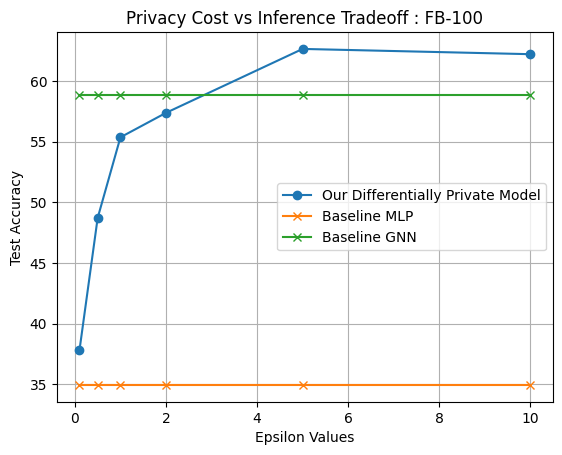

In [ ]:
import matplotlib.pyplot as plt

# Assuming metrics_list contains dictionaries with 'accuracy' key
accuracy_values = [metrics['test/acc'] for metrics in metrics_list]
baseline_acc = [metrics_base_mlp['test/acc'] for metrics in metrics_list]
baseline_gnn_acc = [metrics_base_gnn['test/acc'] for metrics in metrics_list]
# Plotting
plt.plot(epsilon_values, accuracy_values, marker='o', label = 'Our Differentially Private Model')
plt.plot(epsilon_values, baseline_acc, marker = 'x', label = 'Baseline MLP')
plt.plot(epsilon_values, baseline_gnn_acc, marker = 'x', label = 'Baseline GNN' )
plt.legend()
plt.title('Privacy Cost vs Inference Tradeoff : FB-100')
plt.xlabel('Epsilon Values')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()

In [ ]:
epsilon_values = [0.1, 0.5, 1, 2, 5, 10] # Example epsilon values
delta_value = 'auto'

metrics_list = []

for epsilon in epsilon_values:
    model = EdgeLevelProGAP(num_classes=num_classes_reddit, epsilon=epsilon, delta=delta_value)
    model.setup(reddit_data)
    model.fit()
    metrics = model.test()
    metrics_list.append(metrics)

⠴ overal progress  99/100 epochs ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸  99% 0:00:39           
                    train/acc: 98.968 train/loss: 0.146  val/acc: 98.810 val/loss: 0.152  test/acc: 98.503

In [ ]:
!pip show autodp

Name: autodp
Version: 0.2.3.1
Summary: Automating Differential Privacy Computation
Home-page: https://github.com/yuxiangw/autodp
Author: Yu-Xiang Wang
Author-email: yuxiangw@cs.ucsb.edu
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, matplotlib, numpy, scipy
Required-by: 


In [ ]:
print(metrics_list[0]['test/acc'])

tensor(93.2869)


In [ ]:
# import matplotlib.pyplot as plt

# # Assuming metrics_list contains dictionaries with 'accuracy' key
# accuracy_values = [metrics['test/acc'] for metrics in metrics_list]
# baseline_acc = [metrics_base_mlp_reddit['test/acc'] for metrics in metrics_list]
# baseline_gnn_acc = [metrics_pro_reddit['test/acc'] for metrics in metrics_list]
# # Plotting
# plt.plot(epsilon_values, accuracy_values, marker='o')
# plt.title('Privacy Cost vs Inference Tradeoff : Reddit Data')
# plt.xlabel('Epsilon Values')
# plt.ylabel('Test Accuracy')
# plt.grid(True)
# plt.show()

In [ ]:
metrics_base_mlp_reddit['test/acc']

tensor(82.2602)

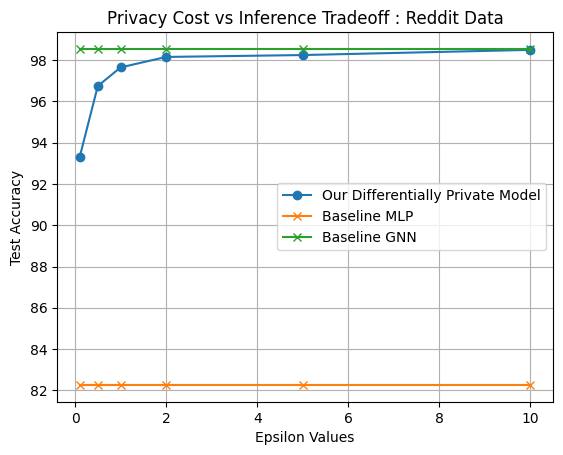

In [ ]:
import matplotlib.pyplot as plt

# Assuming metrics_list contains dictionaries with 'accuracy' key
accuracy_values = [metrics['test/acc'] for metrics in metrics_list]
baseline_acc = [metrics_base_mlp_reddit['test/acc'] for metrics in metrics_list]
baseline_gnn_acc = [metrics_pro_reddit['test/acc'] for metrics in metrics_list]
# Plotting
plt.plot(epsilon_values, accuracy_values, marker='o', label = 'Our Differentially Private Model')
plt.plot(epsilon_values, baseline_acc, marker = 'x', label = 'Baseline MLP')
plt.plot(epsilon_values, baseline_gnn_acc, marker = 'x', label = 'Baseline GNN' )
plt.legend()
plt.title('Privacy Cost vs Inference Tradeoff : Reddit Data')
plt.xlabel('Epsilon Values')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()